In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost

from functions import make_dataset

from functions import make_portfolio

from sklearn.utils import shuffle

import time

import pickle

In [2]:
import datetime

In [2]:
xgboost.__file__

'C:\\Users\\Chirag\\anaconda3\\lib\\site-packages\\xgboost\\__init__.py'

In [3]:
features2 = pd.read_pickle("training_sets/features2")

In [4]:
Date2 = np.load("training_sets/Date2.npy", allow_pickle = True)

In [5]:
Tickers2 = np.load("training_sets/Tickers2.npy", allow_pickle = True)

In [6]:
with open('Training_window_test/top_50.pkl', 'rb') as f:
    top_50 = pickle.load(f)

In [6]:
cols = np.random.choice(top_50, 15, replace = False)

In [7]:
cols_list = []

In [11]:

for i in range(5):
    cols_list.append(np.random.choice(top_50, 40, replace = False))

In [73]:
sp500 = pd.read_pickle("External_data/sp500", np.random.choice(top_50, 15, replace = False))

In [7]:
def make_dataset_eval(df, training_window, prediction_window, eval_size, prediction_date_number, Date_array, cols, pred_col):
    
    training_period = Date_array[prediction_date_number - training_window - prediction_window + 1: prediction_date_number - prediction_window +1]

    prediction_period = Date_array[prediction_date_number :prediction_date_number + eval_size + 1]
    
    X_train = shuffle(df.loc[training_period, np.append(cols, pred_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)
    
    
    
    X_test = shuffle(df.loc[prediction_period, np.append(cols, pred_col)])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    Y_test = X_test.pop(pred_col)
    
    return X_train, X_test, Y_train, Y_test

In [13]:
def make_dataset_eval_with_extra_return_40_term(df, training_window, prediction_window, eval_size, prediction_date_number, Date_array, cols, pred_col):
    
    training_period = Date_array[prediction_date_number - training_window - prediction_window + 1: prediction_date_number - prediction_window +1]

    prediction_period = Date_array[prediction_date_number :prediction_date_number + eval_size + 1]
    
    X_train = shuffle(df.loc[training_period, np.append(cols, pred_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)
    
    
    
    X_test = shuffle(df.loc[prediction_period, np.append(np.append(cols, pred_col), "return_40")])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    Y_test = X_test.pop(pred_col)
    Y_return_40 = X_test.pop("return_40")
    
    return X_train, X_test, Y_train, Y_test, Y_return_40

In [8]:
def make_class_multi(col_name, features_date_indexed, Date_array, n_classes):
    
    to_append = np.array([])
    
    for Date1 in Date_array:
        
        the_column = features_date_indexed.loc[Date1, col_name].copy()
        
        if np.sum(the_column.isna()) / len(the_column) > 0.4:
            
            to_append = np.append(to_append, [np.nan] * len(the_column))
            
        else:
            
            cutoffs = [np.nanpercentile(the_column, 100 - i*(100/n_classes)) for i in range(n_classes+1)]
            cutoffs[0] += 1
        
            def map_func(x):

                for i in range(n_classes):
                    if x >= cutoffs[i+1] and x < cutoffs[i]:
                        return i
                    
            mapped = the_column.map(map_func, na_action = "ignore")
            
            to_append = np.append(to_append, mapped)
            
    return to_append

In [9]:
multi = make_class_multi("return_40", features2, Date2, 20)

In [20]:
np.sum(np.where(features2["Class_binary_40_20"] == 0)[0] != (np.where(multi == 0)))

0

In [21]:
features2["Class_multi_40_20"] = multi

In [14]:
params1 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'multi:softprob',
  'subsample': 0.9,
'num_class' : 2,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0,
    "eval_metric": "mlogloss"
}

In [318]:
Date2[565]

'2017-05-25'

In [11]:
X_train, X_eval, Y_train, Y_eval = make_dataset_eval(features2, 200, 40, 35, 565, Date2, cols, "Class_binary_40_20")

NameError: name 'make_dataset_eval' is not defined

In [153]:
list(cols_list[0])

['OBV_10',
 'volstd_240',
 'Retained Earnings/Total Liabilities',
 'RSI_14',
 'Price to Earnings Ratio (quarterly)_QC',
 'Total Current Assets/Total Assets_YC']

In [15]:
unique_cols = np.array([])
for j in cols_list:
    unique_cols = np.append(unique_cols, j)
    
unique_cols = np.unique(unique_cols)

In [18]:
unique_cols

array(['ABAND_indicator_10', 'ABAND_signal_20', 'ADX_1_11', 'ADX_1_23',
       'AROON_120', 'Accounts & Notes Receivable/Revenue',
       'Accounts & Notes Receivable/Revenue_YC', 'BOL_indicator_10',
       'BOL_indicator_80', 'Book to Market Value',
       'Book to Market Value_QC', 'CMO_120', 'CMO_160',
       'Cash & Cash Equivalents/Total Liabilities_QC',
       'Cost of Revenue_QC', 'DEMA_160', 'EV/FCF',
       'Enterprise Value/EBITDA_YC', 'Free Cash Flow/Revenue_YC',
       'Free Cash Flow/Shares Outstanding', 'MFI_40', 'Net Income_QC',
       'OBV_10', 'OBV_40', 'Operating Expenses/Revenue_QC',
       'Payables & Accruals/Cost of Revenue_YC',
       'Price to Earnings Ratio (quarterly)_QC',
       'Price to Sales Ratio (quarterly)',
       'Property, Plant & Equipment, Net',
       'Property, Plant & Equipment, Net_QC', 'RSI_112', 'RSI_14',
       'RSI_56', 'Retained Earnings/Total Liabilities',
       'Retained Earnings/Total Liabilities_YC', 'Revenue',
       'Shares (Diluted

In [20]:
"""
make_dataset_eval_with_return_40_as_eval_target, so that it is easier to have the average return as the eval metric

"""
X_train, X_eval, Y_train, Y_eval, Y_eval_return_40 = make_dataset_eval_with_extra_return_40_term(features2, 200, 40, 35, 425, Date2, unique_cols, "Class_binary_40_20")

In [287]:
prediction_period = Date2[565 :565 + 35 + 1]

In [21]:
train_weights = Y_train.map({0:19, 1:1})


In [20]:
xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols, weight = train_weights)
xgeval = xgboost.DMatrix(X_eval.values, Y_eval.values, feature_names = cols)


In [182]:
float(np.nan)

nan

In [26]:
def return_metric(predt: np.ndarray, dtrain: xgboost.DMatrix):
    
    try:
        b = np.mean(Y_eval_return_40[np.argsort(predt[:,0])[::-1][:12]])
        b = str(round(b, 1))
        c = np.mean(Y_eval_return_40[np.argsort(predt[:,0])[::-1][:100]])
        c = str(round(c, 1))
        d = np.mean(Y_eval_return_40[np.argsort(predt[:,0])[::-1][:1000]])
        d = str(round(d, 1))
        
        
        if "-" in b:
            b = b.replace("-", "").replace(".", "").zfill(3).rjust(4, "1")
        else:
            b = b.replace(".", "").zfill(3).rjust(4, "2")
        
        if "-" in c:
            c = c.replace("-", "").replace(".", "").zfill(3).rjust(4, "1")
        else:
            c = c.replace(".", "").zfill(3).rjust(4, "2")
          
        if "-" in d:
            d = d.replace("-", "").replace(".", "").zfill(3).rjust(4, "1")
        else:
            d = d.replace(".", "").zfill(3).rjust(4, "2")
            
        return 'avg_return', float(b + c + d)
    
    except:
        return "avg_return", float(np.nan)

In [173]:
for i in cols:
    if i not in unique_cols:
        print(i)

In [31]:
data = {}
start_time_master = time.perf_counter()
for indx, cols in enumerate(cols_list):
    if time.perf_counter() - start_time_master > 2700:
        time.sleep(600)
        start_time_master = time.perf_counter()
        print("sleeping")
        
    if indx >=10:
        boost_round_val = 1000
    else:
        boost_round_val = 500
    a = {}
    start_time = time.perf_counter()
    X_train_sub = X_train[cols]
    X_eval_sub = X_eval[cols]
    
    xgtrain = xgboost.DMatrix(X_train_sub.values, Y_train.values, feature_names = cols, weight = train_weights)
    xgeval = xgboost.DMatrix(X_eval_sub.values, Y_eval.values, feature_names = cols)
    
    
    bst = xgboost.train(params1, xgtrain, num_boost_round = boost_round_val, evals = [(xgeval, "eval"), (xgtrain, "train")], evals_result = a, verbose_eval = False, feval =  return_metric)
    
    data[str(indx)] = a.copy()
    print(time.perf_counter() - start_time)
    
    

194.10516210000014
202.3023892000001
191.8147388
191.59056320000013
190.20793390000017
201.31992809999997
200.64506120000033
200.82705720000013
200.63046310000027
200.7598038000001
444.7147772000003
443.9302623000003
sleeping
443.2594879999997
445.35737659999995
447.47943810000015
510.3367180000005
508.32792229999995
509.16345379999984
sleeping
506.6406971000006
509.0141782999999


In [15]:
with open("BoostingExperimentsData/results.pkl", "rb") as f:
    data = pickle.load(f)

In [21]:
with open("BoostingExperimentsData/results2.pkl", "rb") as f:
    data = pickle.load(f)

In [32]:
with open("results2.pkl", "wb") as f:
    pickle.dump(data, f)

In [19]:
with open("cols_list2.pkl", "wb") as f:
    pickle.dump(cols_list, f)

In [9]:
def decode(string):
    string = str(string)
    string = string[:3] + "." + string[-1]
    if string[0] == "1":
        
        string = float(string.replace("1", "-", 1))
    else:
        string = float(string.replace("2", "0", 1))
    return string

In [23]:
master = []
for indx in range(20):
    recovered = []
        
    for j in data[str(indx)]["eval"]["avg_return"]:

        lvl2 = []

        for string in [str(j)[:4], str(j)[4:8], str(j)[8:12]]:
            lvl2.append(decode(string))

        recovered.append(lvl2)
        
    master.append(recovered)
        

In [26]:
master_eval_logloss = []
for indx in range(20):
    
    master_eval_logloss.append(data[str(indx)]["eval"]["mlogloss"])

In [27]:
master_train_logloss = []
for indx in range(20):
    
    master_train_logloss.append(data[str(indx)]["train"]["mlogloss"])

In [ ]:
"""
what we want to do is determine a somewhat optimal num boost rounds that almost guarantees the model performing the highest
"""

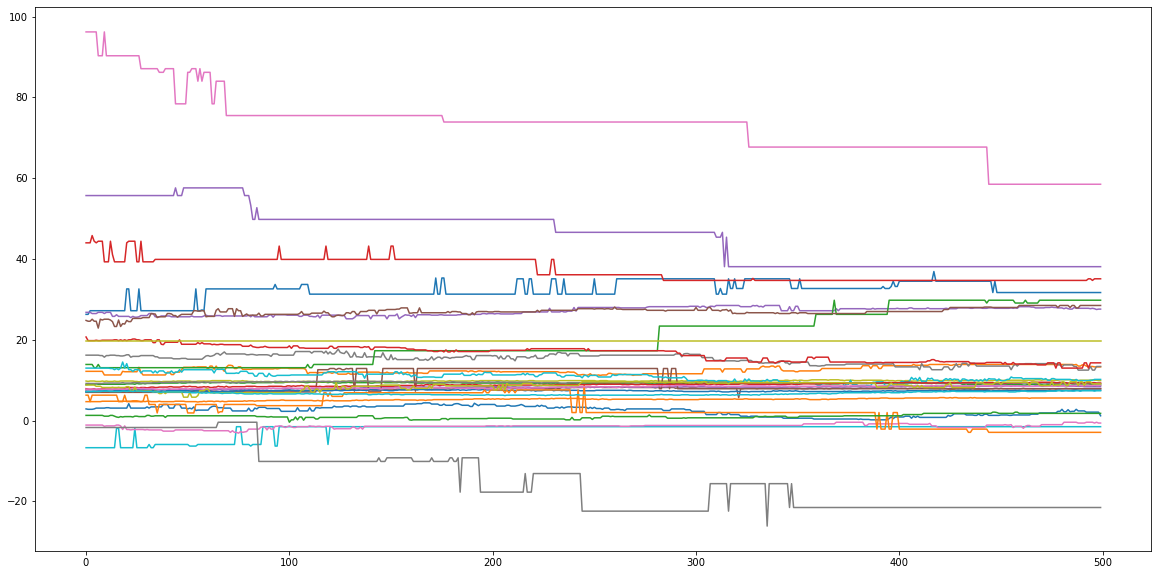

In [53]:

plt.figure(figsize = (20, 10))
plt.ion()
mean_1000 = []

for i in range(10,20):

    for j in range(3):
        plt.plot(np.array(master[i])[:,j][500:])
        mean_1000.append(np.array(master[i])[:,j][500:])



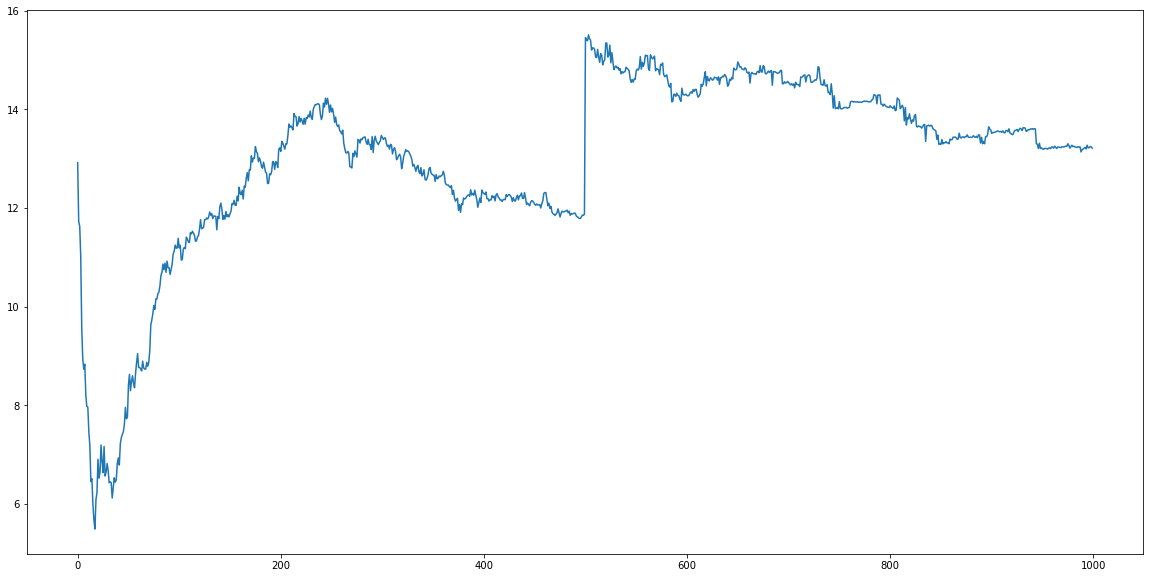

In [61]:
plt.figure(figsize = (20, 10))
plt.plot(np.append(np.mean(mean_500, axis = 0), np.mean(mean_1000, axis = 0)))

In [64]:
len(mean_1000)

30

In [ ]:
np.append(np.mean(mean_500[45:], axis = 0) ,np.mean(mean_1000[15:],axis = 0))

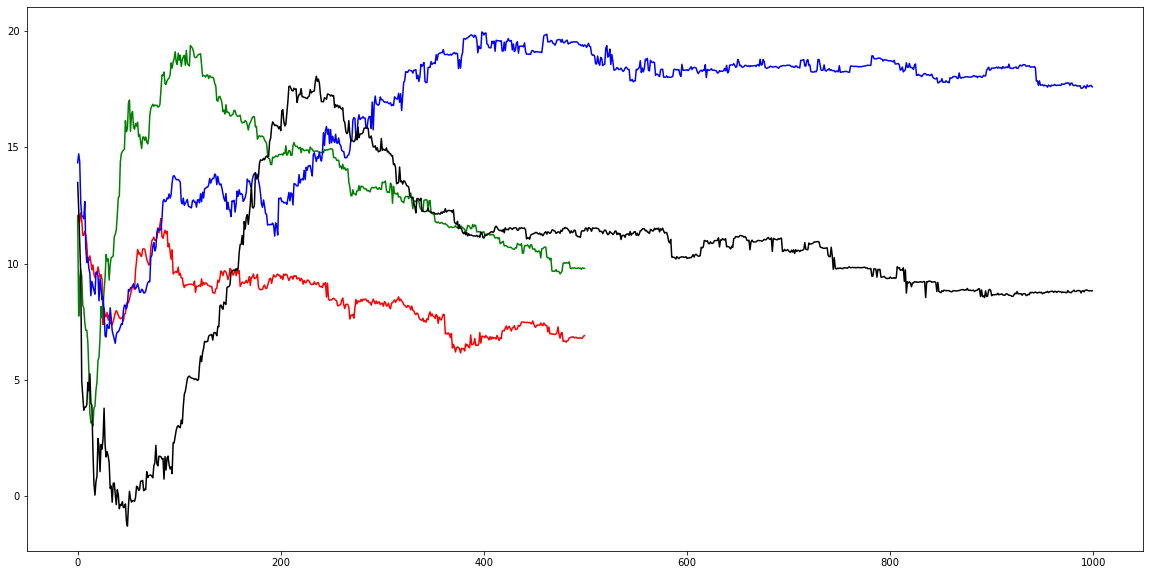

In [65]:
plt.figure(figsize = (20, 10))
plt.plot(np.mean(mean_500[:15], axis = 0), "r")
plt.plot(np.mean(mean_500[15:30], axis = 0), "g")
plt.plot(np.append(np.mean(mean_500[30:45], axis = 0) ,np.mean(mean_1000[:15],axis = 0)), "b")
plt.plot(np.append(np.mean(mean_500[45:], axis = 0) ,np.mean(mean_1000[15:],axis = 0)), "black")

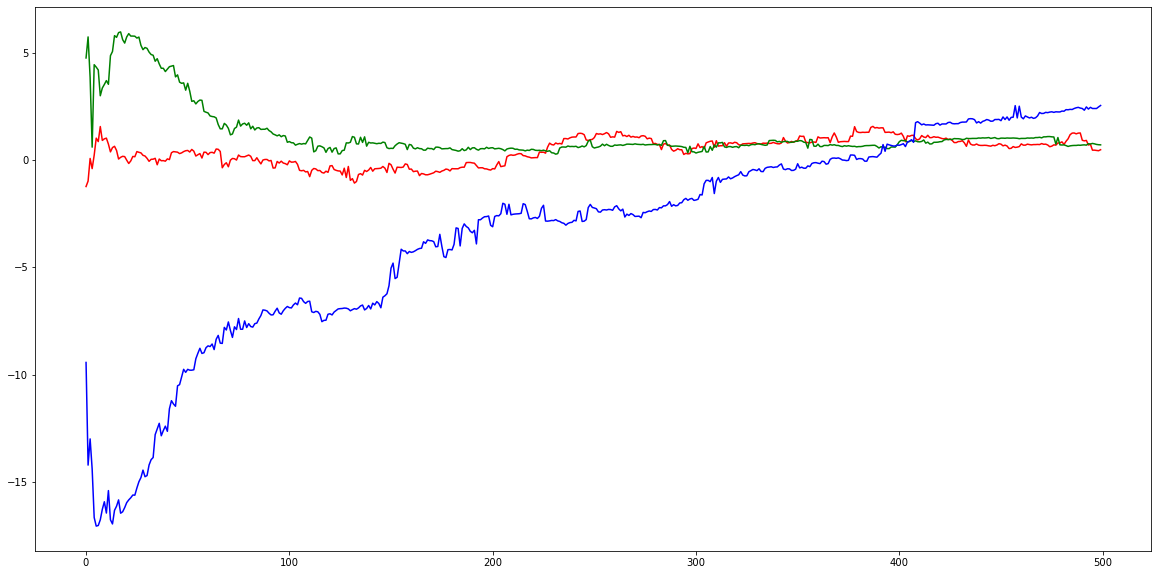

In [340]:
"""
r is col size 6, g is col size 15, b is col size 25
"""
plt.figure(figsize = (20, 10))
plt.plot(np.mean([np.mean(mean[:5], axis = 0), np.mean(mean[15:20],axis = 0), np.mean(mean[30:35], axis = 0)], axis = 0), "r")
plt.plot(np.mean([np.mean(mean[5:10], axis = 0), np.mean(mean[20:25],axis = 0), np.mean(mean[35:40], axis = 0)], axis = 0), "g")
plt.plot(np.mean([np.mean(mean[10:15], axis = 0), np.mean(mean[25:30],axis = 0), np.mean(mean[40:45], axis = 0)], axis = 0), "b")




In [31]:
len(mean)

60

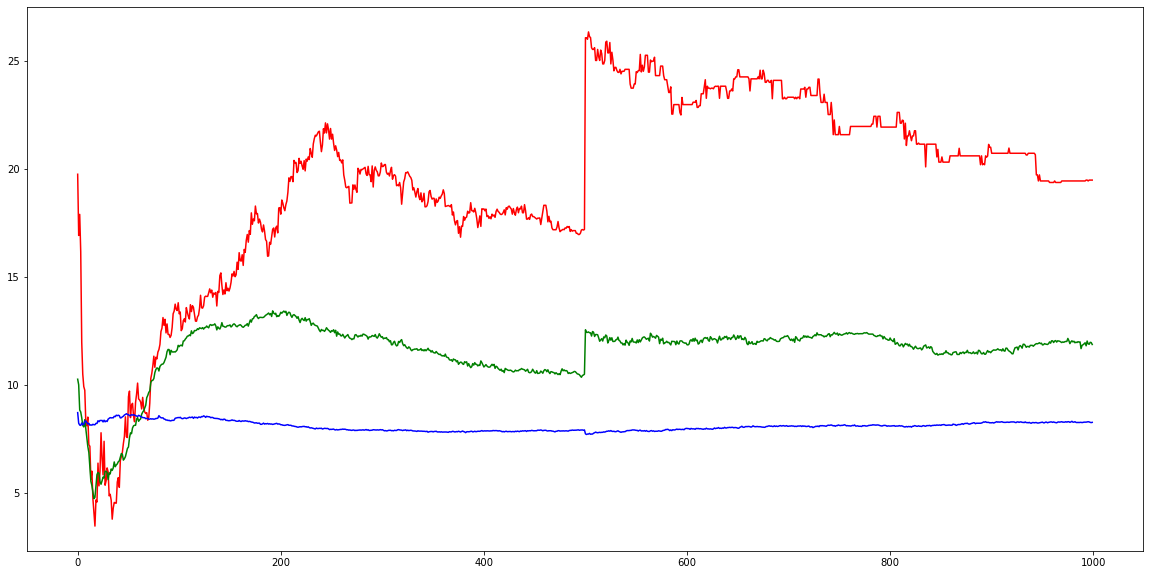

In [66]:
"""
red is top 12, green is top 100 and blue is 1000 0's
"""
plt.figure(figsize = (20, 10))
plt.plot(np.append(np.mean(mean_500[::3], axis = 0), np.mean(mean_1000[::3], axis = 0)), "r")
plt.plot(np.append(np.mean(mean_500[1::3], axis = 0), np.mean(mean_1000[1::3],axis = 0)), "g")
plt.plot(np.append(np.mean(mean_500[2::3], axis = 0), np.mean(mean_1000[2::3], axis = 0)), "b")

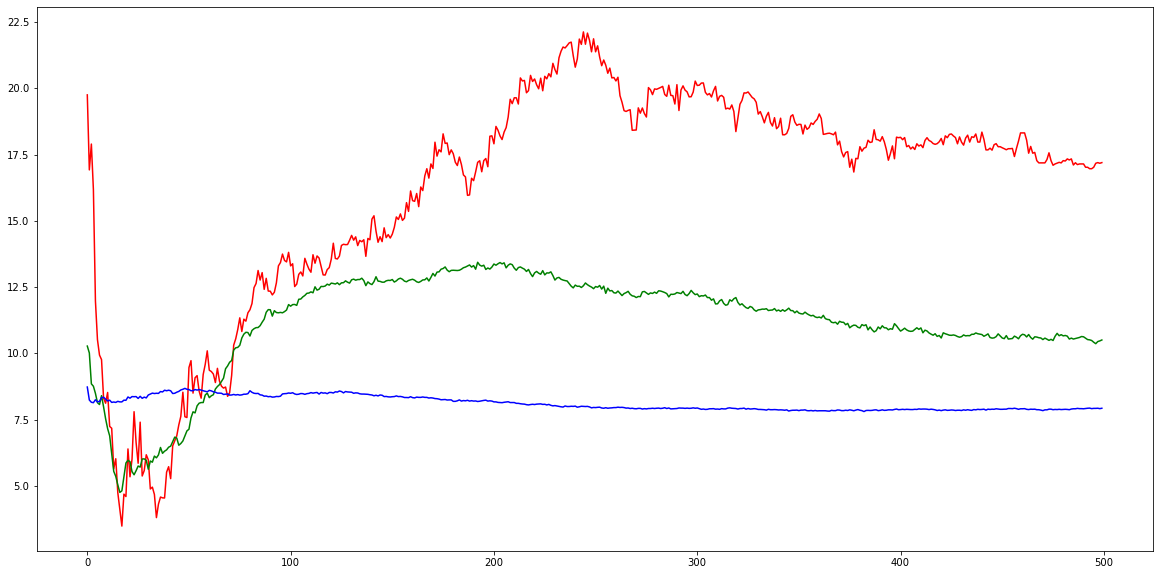

In [34]:
"""
red is top 12 predicted 0's, green is 100 0's and blue is 1000 0's
keep in mind that this is still only on one date
"""
plt.figure(figsize = (20, 10))
plt.plot(np.mean(mean[:20], axis = 0), "r")
plt.plot(np.mean(mean[20:40], axis = 0), "g")
plt.plot(np.mean(mean[40:], axis = 0), "b")

In [72]:
indx_of_max = []
for i in range(20):
    for j in range(3):
        indx_of_max.append(np.argmax(np.array(master[i])[:,j]))

In [74]:
indx_of_max = np.reshape(indx_of_max, (-1, 3))

In [76]:
"""
mean boosting round for highest performance, importantly > 1000 is underrepresented because 
we only did it for half the cols, althogugh it does not seem like it would have made a 
difference for col size 6 and 15
"""
np.mean(indx_of_max), np.std(indx_of_max)

(156.48333333333332, 240.14859925101004)

In [82]:
"""
mean for col size = 6
"""
np.mean(indx_of_max[:5]), np.std(indx_of_max[:5])

(96.6, 128.7699757966377)

In [83]:
"""
mean for col size = 15
"""
np.mean(indx_of_max[5:10]), np.std(indx_of_max[5:10])

(86.73333333333333, 99.66508359946772)

In [84]:
"""
mean for col size = 25
"""
np.mean(indx_of_max[10:15]), np.std(indx_of_max[10:15])

(281.4, 326.6322702979606)

In [85]:
"""
mean for col size = 40
"""
np.mean(indx_of_max[15:]), np.std(indx_of_max[15:])

(161.2, 270.93251312211805)

In [78]:
"""
mean for portfolio size = 12
"""
np.mean(indx_of_max[:,0]), np.std(indx_of_max[:,0])

(187.8, 270.9857191809192)

In [79]:
"""
mean for portfolio size = 100
"""
np.mean(indx_of_max[:,1]), np.std(indx_of_max[:,1])

(195.75, 267.4402503364069)

In [80]:
"""
mean for portfolio size = 1000
"""
np.mean(indx_of_max[:,2]), np.std(indx_of_max[:,2])

(85.9, 143.35930384875618)

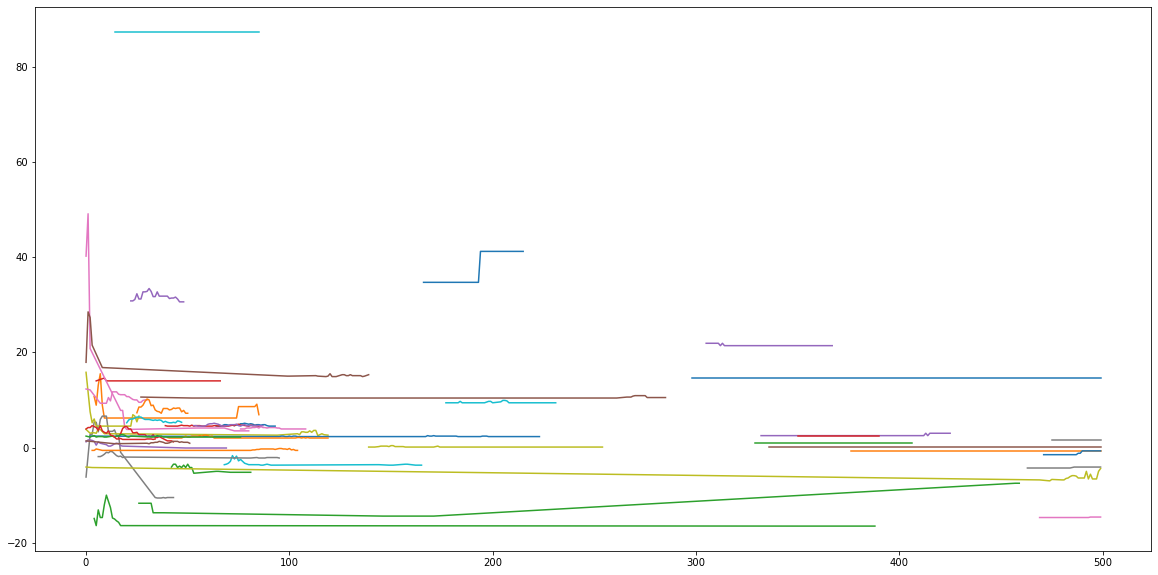

In [252]:
#plt.plot(np.where(np.array(master[0])[:,0] >= np.percentile(np.array(master[0])[:,0], 90))[0], np.array(master[0])[:,0][np.where(np.array(master[0])[:,0] >= np.percentile(np.array(master[0])[:,0], 90))])


plt.figure(figsize = (20, 10))
plt.ion()
for j in range(3):
    for i in range(15):
        plt.plot(np.where(np.array(master[i])[:,j] >= np.percentile(np.array(master[i])[:,j], 95))[0], np.array(master[i])[:,j][np.where(np.array(master[i])[:,j] >= np.percentile(np.array(master[i])[:,j], 95))])


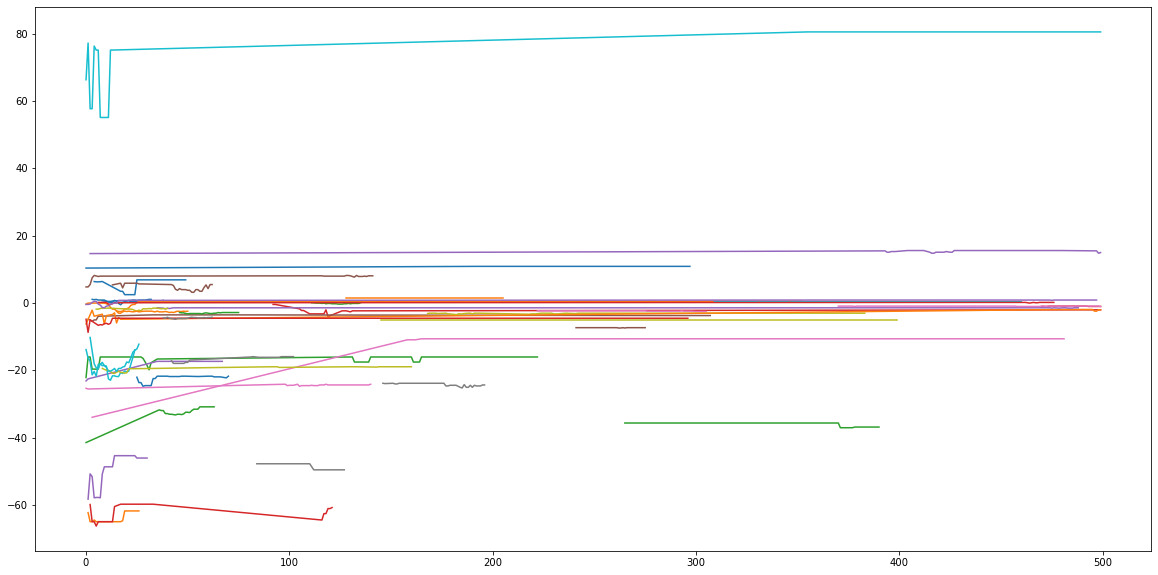

In [269]:
plt.figure(figsize = (20, 10))
plt.ion()
for j in range(3):
    for i in range(15):
        plt.plot(np.where(np.array(master[i])[:,j] <= np.percentile(np.array(master[i])[:,j], 5))[0], np.array(master[i])[:,j][np.where(np.array(master[i])[:,j] <= np.percentile(np.array(master[i])[:,j], 5))])

In [282]:
len(mean)

45

In [283]:
np.shape(mean)

(45, 500)

In [288]:
np.mean(features2.loc[prediction_period, "return_40"])

4.637144813440129

In [290]:
test = features2.loc[prediction_period].replace([np.inf, -np.inf], np.NaN).dropna(axis = 0)


In [298]:
len(features2.loc[prediction_period])

68208

In [301]:
num_nan = (features2.loc[prediction_period].isna().sum() / 68208 * 100).values

In [313]:
features2.columns[269]

False

In [306]:
len(features2)

1450251

In [307]:
num_nan_full = (features2.isna().sum() / 1450251 * 100)

In [303]:
np.argmax(num_nan)

269

In [295]:
np.mean(Y_eval_return_40)

0.2211431132392279

In [330]:
len(cols_list)

15

In [327]:
np.shape(mean[15:])

(30, 500)

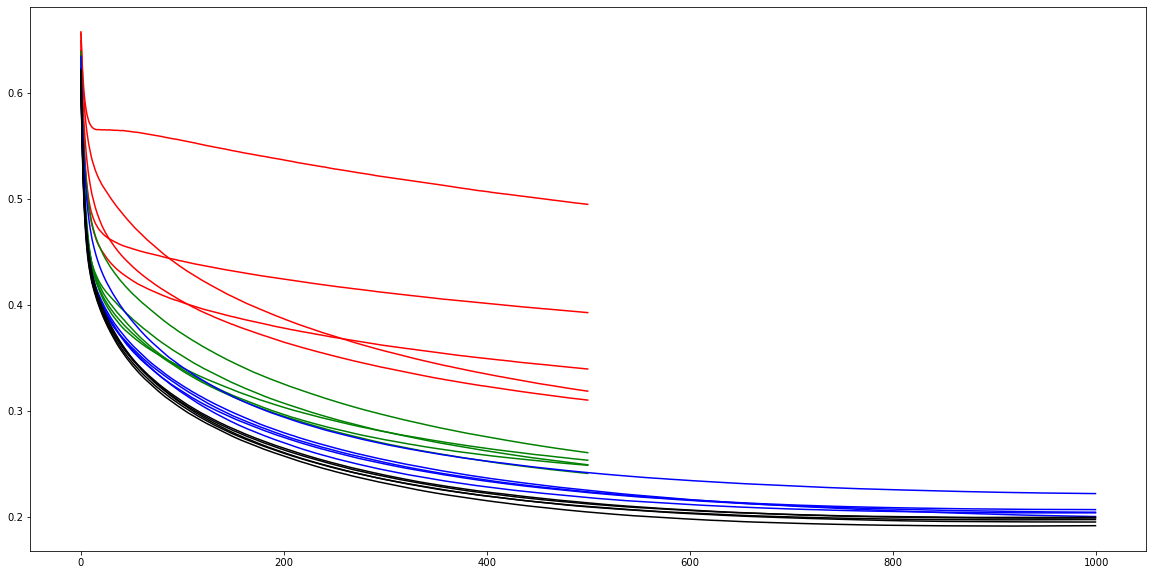

In [88]:
plt.figure(figsize = (20, 10))
plt.ion()
mean_eval_logloss = []

"""
red is col length 6, green is col length 15 and blue is col length 25
"""

for i in range(20):
    if i < 5:
        plt.plot(np.array(master_eval_logloss[i]), "r")
        mean_eval_logloss.append(np.array(master_eval_logloss[i]))
    elif i < 10:
        plt.plot(np.array(master_eval_logloss[i]), "g")
        mean_eval_logloss.append(np.array(master_eval_logloss[i]))
        
    elif i < 15:
        
        plt.plot(np.array(master_eval_logloss[i]), "b")
        mean_eval_logloss.append(np.array(master_eval_logloss[i]))
        
    else:
        plt.plot(np.array(master_eval_logloss[i]), "black")
        mean_eval_logloss.append(np.array(master_eval_logloss[i]))
        
#plt.xlim(400, 500)
#plt.ylim(0.15, 0.25)

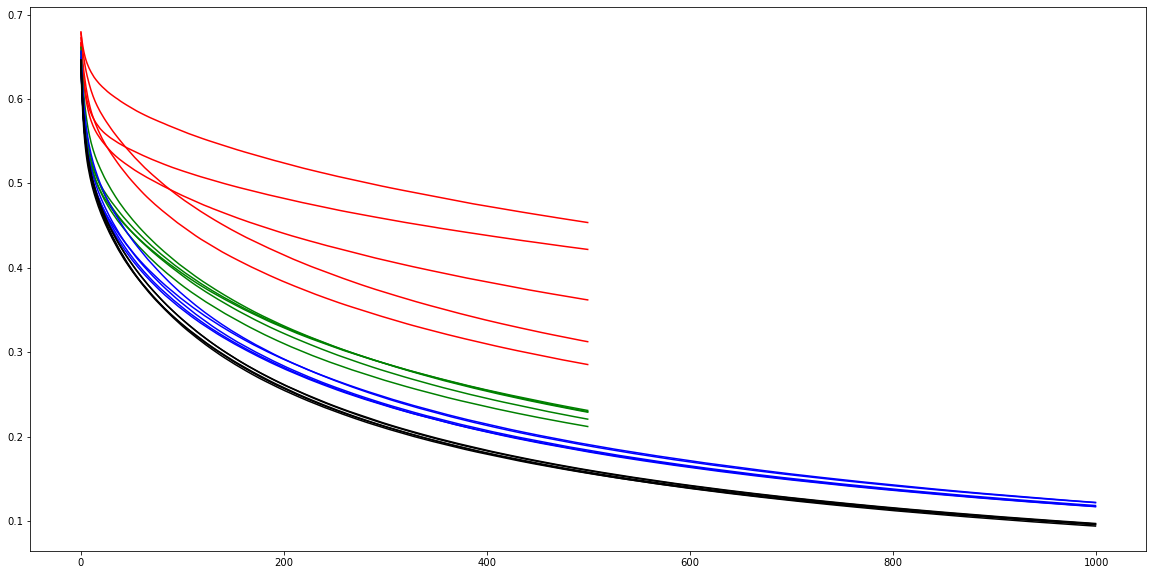

In [89]:
plt.figure(figsize = (20, 10))
plt.ion()
mean_train_logloss = []

"""
i < 5 is cols of len(6), < 10 is len(15) and else is 25
"""

for i in range(20):
    if i < 5:
        plt.plot(np.array(master_train_logloss[i]), "r")
        mean_train_logloss.append(np.array(master_train_logloss[i]))
    elif i < 10:
        plt.plot(np.array(master_train_logloss[i]), "g")
        mean_train_logloss.append(np.array(master_train_logloss[i]))
        
    elif i < 15:
        plt.plot(np.array(master_train_logloss[i]), "b")
        mean_train_logloss.append(np.array(master_train_logloss[i]))
        
    else:
        plt.plot(np.array(master_train_logloss[i]), "black")
        mean_train_logloss.append(np.array(master_train_logloss[i]))
        
        

In [208]:
np.array(recovered)

(500, 3)

In [35]:
data1 == data

False

In [25]:
data

{'0': {'eval': OrderedDict([('mlogloss', [0.656446]),
               ('avg_return', [233810042039.0])]),
  'train': OrderedDict([('mlogloss', [0.678059]), ('avg_return', [nan])])},
 '1': {'eval': OrderedDict([('mlogloss', [0.649356]),
               ('avg_return', [204120522091.0])]),
  'train': OrderedDict([('mlogloss', [0.67237]), ('avg_return', [nan])])},
 '2': {'eval': OrderedDict([('mlogloss', [0.640615]),
               ('avg_return', [215621182079.0])]),
  'train': OrderedDict([('mlogloss', [0.666587]), ('avg_return', [nan])])},
 '3': {'eval': OrderedDict([('mlogloss', [0.639131]),
               ('avg_return', [256621532068.0])]),
  'train': OrderedDict([('mlogloss', [0.665633]), ('avg_return', [nan])])},
 '4': {'eval': OrderedDict([('mlogloss', [0.65779]),
               ('avg_return', [104720272092.0])]),
  'train': OrderedDict([('mlogloss', [0.679427]), ('avg_return', [nan])])},
 '5': {'eval': OrderedDict([('mlogloss', [0.639126]),
               ('avg_return', [214321212090

In [29]:
time.sleep(1)

In [ ]:
189.60761809999985
193.64577409999947
191.16010129999995
192.0845849999996
189.24913339999966
202.87948250000045
201.8296074
203.09425209999972
202.4761198999995
201.5795420000004
223.44107340000028
224.57843979999961
224.46452390000013
223.62194199999976
224.1558382000003

In [10]:
xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols)
xgeval = xgboost.DMatrix(X_eval.values, Y_test.values, feature_names = cols)

In [15]:
Y_test = Y_eval.loc[Date2[375]]
X_test = X_eval.loc[Date2[375]]

In [16]:
xgtest = xgboost.DMatrix(X_test.values, feature_names =cols)

In [30]:
callback1 = xgboost.callback.EarlyStopping(metric_name= "mlogloss", data_name= "train", save_best=True, min_delta=0.001)

In [114]:
preva = a

In [21]:
a = {}

In [100]:
del bst

In [35]:
xgboost.model

AttributeError: module 'xgboost' has no attribute 'model'

In [129]:
bst.save_model("test_model")

bst2 = xgboost.Booster()

bst2.load_model("test_model")

In [48]:
preds = bst.predict(xgeval)

In [51]:
np.sum(preds[:,0] > 0.5)

0

In [22]:
params1 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'multi:softprob',
  'subsample': 0.9,
'num_class' : 2,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0,
    "eval_metric": "mlogloss"
}

In [ ]:
def num_0s(predt: np.ndarray, dtrain: xgboost.DMatrix):
    
    y = dtrain.get_label()
    
    np.sum(predt[:,0] > 0.5)
    
    return 'num_0s', float(np.sum(predt[:,0] > 0.5))

In [80]:
def metric69(predt: np.ndarray, dtrain: xgboost.DMatrix):
    
    y = dtrain.get_label()
    b = str(round(float(np.sum(y[np.argsort(predt[:,0])[::-1][:100]] == 0) / 100 * 100), 2))
    c = str(round(float(np.sum(y[np.argsort(predt[:,0])[::-1][:1000]] == 0) / 1000 * 100), 2))
    
    b = b.replace(".", "777")
    c = c.replace(".", "888")
    
    return 'metric69', float(b + "999" + c)



In [99]:
predt = bst.predict(xgeval)

In [103]:
b = np.mean(Y_eval_return_40[np.argsort(predt[:,0])[::-1][:12]])

In [105]:
b = str(round(b, 1))

In [107]:
c = np.mean(Y_eval_return_40[np.argsort(predt[:,0])[::-1][:100]])

In [109]:
c = str(round(c, 1))

In [111]:
for val in [b, c]:
    if "-" in val:
        val = val.replace("-", "").replace(".", "").zfill(3).rjust(4, "1")
    else:
        val = val.replace(".", "").zfill(3).rjust(4, "2")

In [113]:
c

'0.3'

In [106]:
b

'-12.1'

In [110]:
c

'0.3'

In [101]:
return_metric(predt, xgeval)

('nan', 1.0)

In [138]:
def return_metric(predt: np.ndarray, dtrain: xgboost.DMatrix):
    
    try:
        return 'avg_return', float(np.mean(Y_eval_return_40[np.argsort(predt[:,0])[::-1][:12]]))
    
    except:
        return "err", float(1)
    


In [116]:
a = {}

In [97]:
a = {}

In [26]:
cols_list

[array(['Total Equity_YC', 'OBV_10',
        'Total Assets/Share Capital & Additional Paid-In Capital_QC',
        'OBV_40', 'AROON_120', 'Property, Plant & Equipment, Net_QC',
        'CMO_120', 'BOL_indicator_10', 'close_20/Close_120',
        'Free Cash Flow/Shares Outstanding', 'CMO_160', 'WillR_80',
        'Working Capital_QC', 'Shares (Diluted)/Shares (Basic)_QC',
        'Cost of Revenue_QC'], dtype='<U58'),
 array(['CMO_160', 'close_0/Close_360',
        'Price to Earnings Ratio (quarterly)_QC',
        'Book to Market Value_QC',
        'Accounts & Notes Receivable/Revenue_YC', 'MFI_40', 'RSI_14',
        'ABAND_indicator_10', 'Cost of Revenue_QC', 'close_120/Close_160',
        'WillR_80', 'ABAND_signal_20',
        'Retained Earnings/Total Liabilities_YC', 'BOL_indicator_80',
        'ADX_1_11'], dtype='<U58'),
 array(['Accounts & Notes Receivable/Revenue_YC', 'close_20/Close_120',
        'Retained Earnings/Total Liabilities', 'Book to Market Value_QC',
        'Book to Ma

In [139]:
start_time = time.perf_counter()
bst = xgboost.train(params1, xgtrain, num_boost_round = 10, evals = [(xgeval, "eval"), (xgtrain, "train")], evals_result = a, verbose_eval = True, feval =  return_metric)
print(time.perf_counter() - start_time)

[0]	eval-mlogloss:0.64065	eval-avg_return:-5.55678	train-mlogloss:0.65873	train-err:1.00000
[1]	eval-mlogloss:0.60474	eval-avg_return:-21.00314	train-mlogloss:0.63361	train-err:1.00000
[2]	eval-mlogloss:0.57793	eval-avg_return:-15.03984	train-mlogloss:0.61463	train-err:1.00000
[3]	eval-mlogloss:0.55805	eval-avg_return:-19.29277	train-mlogloss:0.59950	train-err:1.00000
[4]	eval-mlogloss:0.54446	eval-avg_return:-17.51036	train-mlogloss:0.58749	train-err:1.00000
[5]	eval-mlogloss:0.53339	eval-avg_return:-19.82557	train-mlogloss:0.57744	train-err:1.00000
[6]	eval-mlogloss:0.52488	eval-avg_return:-19.82557	train-mlogloss:0.56917	train-err:1.00000
[7]	eval-mlogloss:0.51794	eval-avg_return:-22.31650	train-mlogloss:0.56200	train-err:1.00000
[8]	eval-mlogloss:0.51256	eval-avg_return:-22.31650	train-mlogloss:0.55566	train-err:1.00000
[9]	eval-mlogloss:0.50825	eval-avg_return:-21.43876	train-mlogloss:0.54997	train-err:1.00000
4.681033200000456


In [125]:
j = a["eval"]["avg_return"][0]

In [130]:
j

10561076.0

In [132]:
string

'1056'

In [134]:
string[:3] + "." + a[-1]

KeyError: -1

In [133]:
decode(string)

KeyError: -1

In [137]:
recovered

[[-5.6, -7.6],
 [-21.0, -9.3],
 [-15.0, -6.2],
 [-19.3, -6.5],
 [-17.5, -5.1],
 [-19.8, -4.4],
 [-19.8, -4.9],
 [-22.3, -5.5],
 [-22.3, -4.1],
 [-21.4, -3.2]]

In [237]:
bst.evals()

AttributeError: 'Booster' object has no attribute 'evals'

In [234]:
start_time = time.perf_counter()
bst = xgboost.train(params1, xgtrain, num_boost_round = 1, evals = [(xgeval, "eval"), (xgtrain, "train")], evals_result = a, verbose_eval = True, feval =  return_metric)
for i in range(10):
    bst = xgboost.train(params1, xgtrain, num_boost_round = 1, evals = [(xgeval, "eval"), (xgtrain, "train")], evals_result = a, verbose_eval = True, feval =  return_metric, xgb_model = bst)
    
print(time.perf_counter() - start_time)

[0]	eval-mlogloss:0.62657	eval-avg_return:4.98575	train-mlogloss:0.65345	train-nan:1.00000
[0]	eval-mlogloss:0.58076	eval-avg_return:6.95856	train-mlogloss:0.62521	train-nan:1.00000
[0]	eval-mlogloss:0.54734	eval-avg_return:3.16127	train-mlogloss:0.60334	train-nan:1.00000
[0]	eval-mlogloss:0.52218	eval-avg_return:4.58427	train-mlogloss:0.58529	train-nan:1.00000
[0]	eval-mlogloss:0.50186	eval-avg_return:12.51047	train-mlogloss:0.56961	train-nan:1.00000
[0]	eval-mlogloss:0.48596	eval-avg_return:12.29669	train-mlogloss:0.55613	train-nan:1.00000
[0]	eval-mlogloss:0.47375	eval-avg_return:12.29669	train-mlogloss:0.54470	train-nan:1.00000
[0]	eval-mlogloss:0.46324	eval-avg_return:12.54895	train-mlogloss:0.53401	train-nan:1.00000
[0]	eval-mlogloss:0.45454	eval-avg_return:15.07088	train-mlogloss:0.52443	train-nan:1.00000
[0]	eval-mlogloss:0.44741	eval-avg_return:12.54895	train-mlogloss:0.51622	train-nan:1.00000
[0]	eval-mlogloss:0.44134	eval-avg_return:12.54895	train-mlogloss:0.50866	train-nan:

In [163]:
start_time = time.perf_counter()
bst = xgboost.train(params1, xgtrain, num_boost_round = 10, evals = [(xgeval, "eval"), (xgtrain, "train")], evals_result = a, verbose_eval = True, feval =  return_metric)
print(time.perf_counter() - start_time)

[0]	eval-mlogloss:0.62657	eval-avg_return:4.98575	train-mlogloss:0.65345	train-err:1.00000
[1]	eval-mlogloss:0.57983	eval-avg_return:4.04049	train-mlogloss:0.62457	train-err:1.00000
[2]	eval-mlogloss:0.54625	eval-avg_return:6.44003	train-mlogloss:0.60223	train-err:1.00000
[3]	eval-mlogloss:0.52127	eval-avg_return:12.82811	train-mlogloss:0.58417	train-err:1.00000
[4]	eval-mlogloss:0.50132	eval-avg_return:14.58808	train-mlogloss:0.56889	train-err:1.00000
[5]	eval-mlogloss:0.48609	eval-avg_return:15.54667	train-mlogloss:0.55517	train-err:1.00000
[6]	eval-mlogloss:0.47332	eval-avg_return:15.54667	train-mlogloss:0.54349	train-err:1.00000
[7]	eval-mlogloss:0.46301	eval-avg_return:15.54667	train-mlogloss:0.53315	train-err:1.00000
[8]	eval-mlogloss:0.45500	eval-avg_return:18.96181	train-mlogloss:0.52421	train-err:1.00000
[9]	eval-mlogloss:0.44781	eval-avg_return:18.11717	train-mlogloss:0.51606	train-err:1.00000
3.469582799998534


In [157]:
recovered = []
for j in a["eval"]["avg_return"]:
    recovered.append(str(int(j)).replace("99", ".").replace("88", ".").split("9"))
    

In [ ]:
def return_metric(predt: np.ndarray, dtrain: xgboost.DMatrix):
    
    try:
        b = str(round(float(np.mean(Y_eval_return_40[np.argsort(predt[:,0])[::-1][:12]])), 2))   
        c = str(round(float(np.mean(Y_eval_return_40[np.argsort(predt[:,0])[::-1][:100]])), 2))
        
        b = b.replace(".", "99")
        
        c = c.replace(".", "88").replace("-", "66")

        return 'avg_return', float(b + c)
    
    except:
        return "nan", float(1)

In [159]:
len(recovered)

9

In [90]:
"""
basiclly it is alright that our selection includes 20% 0's in top 100 when by random choice it would be 10%,
nevertheless it could also be selecting a higher number of 9's (rally bad classes) because we know that they are
statistically more similar to the 0's
amend the eval func to take this into account



"""
recovered[0]

['20.0', '17.8']

In [73]:
str(int(j)).replace("777", ".").replace("888", ".").split("999")
str(int(a["eval"]["metric69"][0])).replace("777", ".").replace("888", ".").split("999")

['15.78', '17.8']

In [74]:
int(a["eval"]["metric69"][0])

1577778999178888

In [79]:
6925 / len(X_test) * 100

15.162794771299074

In [67]:
bst

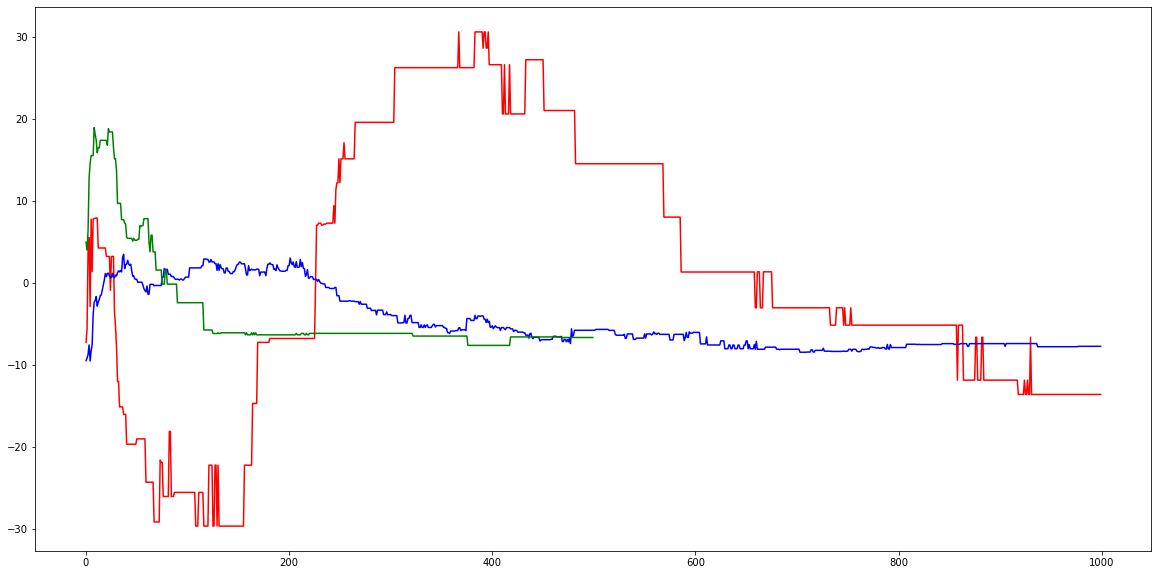

In [146]:
plt.figure(figsize = (20, 10))
plt.plot(np.append(a2["eval"]["avg_return"], a3["eval"]["avg_return"]), "r")
plt.plot(np.array(a1["eval"]["avg_return"]), "b")
plt.plot(np.array(a["eval"]["avg_return"]), "g")

In [66]:
a["eval"]["mlogloss"][::50]

[0.473682,
 0.469148,
 0.464703,
 0.460762,
 0.456761,
 0.453275,
 0.449874,
 0.44686,
 0.443728,
 0.440912,
 0.438278,
 0.435693,
 0.43329,
 0.431075,
 0.429026,
 0.42685,
 0.424969,
 0.423102,
 0.421365,
 0.419513]

In [72]:
portfolio = make_portfolio(12, bst.predict(xgtest)[:,0], X_predict)

In [76]:
Date2[350]

'2016-07-19'

In [73]:
portfolio

['RLJE',
 'PCRX',
 'EGAN',
 'GPRO',
 'AMRK',
 'CDE',
 'CONN',
 'USAP',
 'GEOS',
 'CNXR',
 'FCEL',
 'HALO']

In [75]:
np.mean([features2.loc[Date2[350], j]["return_40"] for j in portfolio])

5.794745501475521

In [ ]:
callbacks = [callback1]

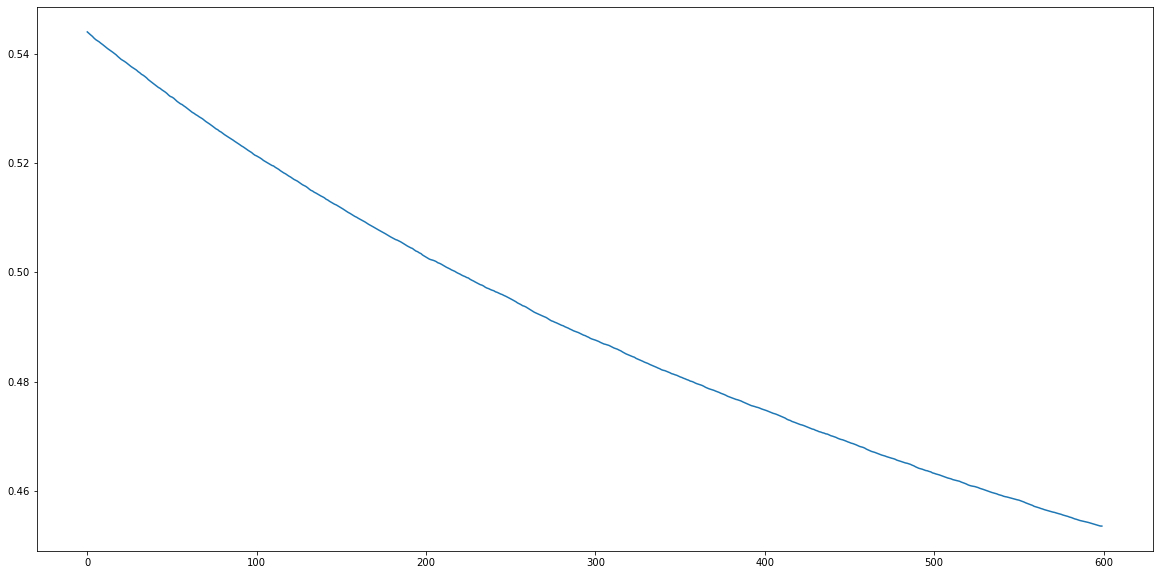

In [100]:
plt.figure(figsize = (20, 10))
plt.plot(a["eval"]["mlogloss"][:])

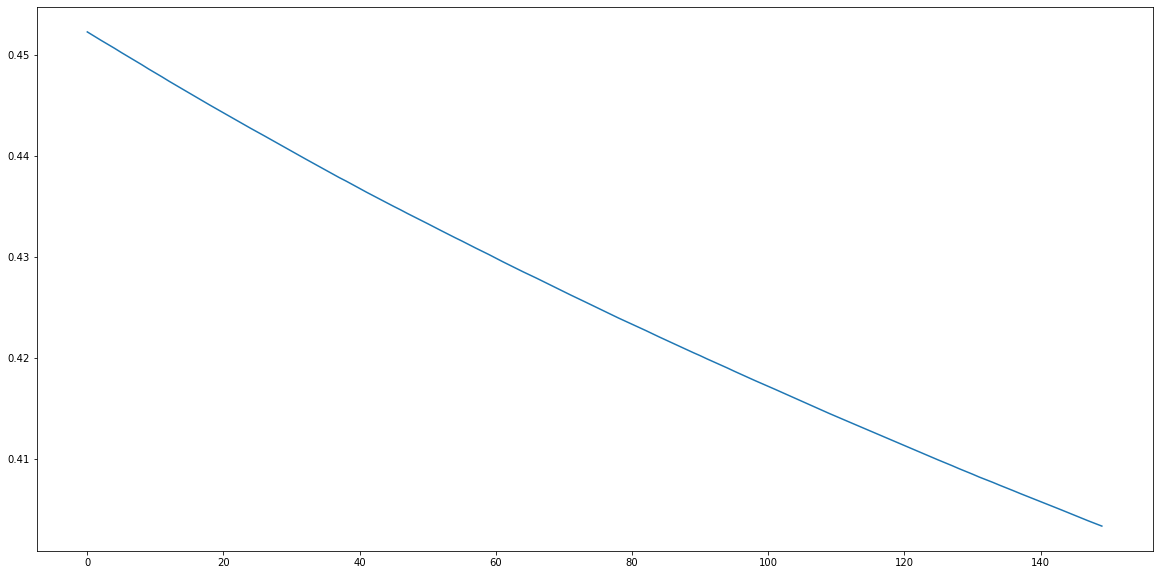

In [88]:
plt.figure(figsize = (20, 10))
plt.plot(a["train"]["mlogloss"])

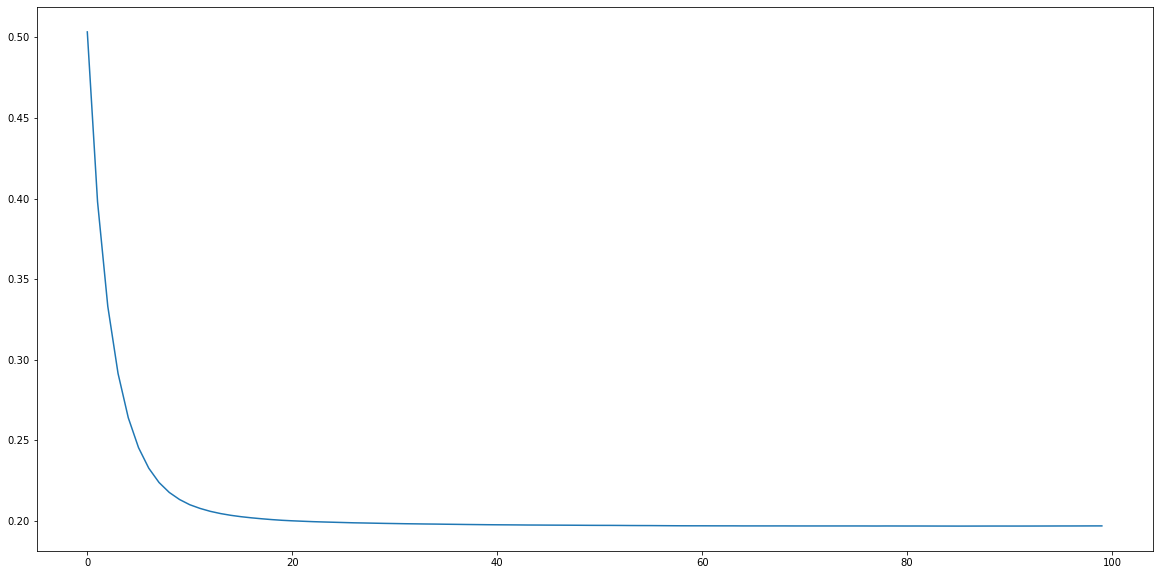

In [29]:
plt.figure(figsize = (20, 10))
plt.plot(a["eval"]["mlogloss"])

In [20]:
"""
for eta = 0.3, num parallel trees = 60

"""

np.argmin(a["eval"]["mlogloss"]), np.min(a["eval"]["mlogloss"])

(85, 0.196872)

In [27]:
np.mean(returns)

10.380431280065586

In [47]:
"""
slighly lower logloss using the 0.1 eta, (still 60 parallel trees) but at the cost of taking 366 boosting iters vs only 85 for the 0.3 eta, although we dont know what type of impact this has on the prediction of 0's maybe that tiny bit is really impactful.
also it started overfitting and the eval loss started increasing past this point
"""
np.argmin(a["eval"]["mlogloss"]), np.min(a["eval"]["mlogloss"])

(66, 0.196635)

In [50]:
np.mean(returns)

10.341575584216647

In [58]:
"""
0.3 eta, 180 trees, took 96 secs for 150 boosting iters (best was reached at 89th iter) and we reached better score than using 0.1 eta in shorter time

"""

np.argmin(a["eval"]["mlogloss"]), np.min(a["eval"]["mlogloss"])

(89, 0.196631)

In [62]:
"""
0.3 eta, 540 trees, took 307 secs for 150 boosting iters. About same performance as the 180 trees in longer time

"""

np.argmin(a["eval"]["mlogloss"]), np.min(a["eval"]["mlogloss"])

(78, 0.196658)

In [65]:
np.mean(returns)

12.165429821062483

In [101]:
portfolio = make_portfolio(12, bst.predict(xgtest)[:,0], X_predict)

In [102]:
returns = [features2.loc[Date2[350], j]["return_40"] for j in portfolio]

In [66]:
portfolio

['PRPO',
 'CONN',
 'ENDP',
 'IMGN',
 'ACW',
 'IONS',
 'ZGNX',
 'GEVO',
 'PRO',
 'HEAR',
 'SRNE',
 'ENPH']

In [91]:
portfolio

['PRPO',
 'ENDP',
 'CONN',
 'RFP',
 'IMGN',
 'ZGNX',
 'IONS',
 'BONT',
 'TLRD',
 'ACW',
 'KTWO',
 'PRO']

In [103]:
portfolio

['PRPO',
 'CONN',
 'IMGN',
 'BONT',
 'ZGNX',
 'RFP',
 'KTWO',
 'TLRD',
 'IONS',
 'ENDP',
 'BOX',
 'RLJE']

In [92]:
np.mean(returns)

12.603863696290695

In [104]:
np.mean(returns)

6.16467730183243

In [108]:
preds = bst.predict(xgtest)

In [118]:
len(np.where(preds[:,0] > 0.5)[0])

343

In [120]:
343 / len(preds)

"""
hmm this would be very interesting to look at to see the num probs for 0's > 0.5 over time, see if its increasing or decreasing, it should ideally be 1/20 but idk. what really matters are that the highest prob ones are trye 0's

"""

0.24257425742574257

In [115]:
9.82e-1

0.982

In [109]:
preds

array([[0.38052118, 0.6194788 ],
       [0.19271514, 0.8072849 ],
       [0.00260303, 0.99739695],
       ...,
       [0.06815809, 0.93184197],
       [0.28741035, 0.7125896 ],
       [0.03584416, 0.96415585]], dtype=float32)